In [1]:
import torch
import torch.nn as nn

In [2]:
sentence = "the quick brown fox jumped over the lazy dog"
words = sentence.split()
words_length = len(words)
vocab = set(words)
vocab_size = len(vocab)

In [3]:
itos = dict(enumerate(vocab))
stoi = {word: i for i, word in itos.items()}
print(itos)
print(stoi)

{0: 'jumped', 1: 'quick', 2: 'brown', 3: 'over', 4: 'fox', 5: 'the', 6: 'lazy', 7: 'dog'}
{'jumped': 0, 'quick': 1, 'brown': 2, 'over': 3, 'fox': 4, 'the': 5, 'lazy': 6, 'dog': 7}


In [4]:
tokens = [stoi[word] for word in words]
print(tokens)

[5, 1, 2, 4, 0, 3, 5, 6, 7]


In [5]:
embed_dim = 9
embed= nn.Embedding(vocab_size, embed_dim)

In [6]:
embed.weight

Parameter containing:
tensor([[ 0.3764, -0.2596, -0.2657,  1.3532, -1.0006, -0.1240,  0.1258,  0.1612,
         -0.0398],
        [-0.0376, -1.7065, -0.8628, -0.1187,  0.2348,  0.0676, -0.4427, -0.0938,
          0.6341],
        [-1.2439,  0.5712,  1.4802,  0.7902, -0.8597, -1.4355,  2.1439, -0.0751,
          0.6651],
        [ 0.2715, -1.1723, -0.7371, -0.1563, -0.2959, -1.2684,  0.7732, -0.9518,
          0.2773],
        [-1.1061,  0.0700, -0.6023,  1.0456,  0.7518, -0.6674, -1.2797,  1.4112,
          0.9882],
        [-2.1183, -0.9989,  1.2306,  1.4776,  1.2060, -0.3601,  0.0821, -0.6141,
          1.3218],
        [ 1.0596,  1.5081, -1.1285, -0.7461,  0.5234,  0.4956,  0.1110, -0.8343,
         -0.2825],
        [-0.4932, -2.6327,  0.2632, -1.5300, -1.1662, -0.8675, -0.6034, -0.6383,
         -0.0580]], requires_grad=True)

In [7]:
with torch.no_grad():
    input = torch.LongTensor(tokens)
    word_embed = embed(input)
word_embed

tensor([[-2.1183, -0.9989,  1.2306,  1.4776,  1.2060, -0.3601,  0.0821, -0.6141,
          1.3218],
        [-0.0376, -1.7065, -0.8628, -0.1187,  0.2348,  0.0676, -0.4427, -0.0938,
          0.6341],
        [-1.2439,  0.5712,  1.4802,  0.7902, -0.8597, -1.4355,  2.1439, -0.0751,
          0.6651],
        [-1.1061,  0.0700, -0.6023,  1.0456,  0.7518, -0.6674, -1.2797,  1.4112,
          0.9882],
        [ 0.3764, -0.2596, -0.2657,  1.3532, -1.0006, -0.1240,  0.1258,  0.1612,
         -0.0398],
        [ 0.2715, -1.1723, -0.7371, -0.1563, -0.2959, -1.2684,  0.7732, -0.9518,
          0.2773],
        [-2.1183, -0.9989,  1.2306,  1.4776,  1.2060, -0.3601,  0.0821, -0.6141,
          1.3218],
        [ 1.0596,  1.5081, -1.1285, -0.7461,  0.5234,  0.4956,  0.1110, -0.8343,
         -0.2825],
        [-0.4932, -2.6327,  0.2632, -1.5300, -1.1662, -0.8675, -0.6034, -0.6383,
         -0.0580]])

In [8]:
from att2conv import attention_DotProduct, show_attention

In [9]:
attention = attention_DotProduct(word_embed, word_embed)
attention.shape

torch.Size([9, 9])

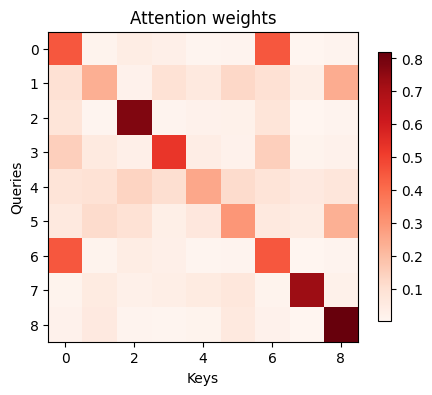

In [10]:
show_attention(attention)

## 使用卷积来替换注意力

很简单的思想，我们计算注意力的时候其实是计算点乘，然后再softmax，这个过程完全可以用卷积来替换

- 我们的句子如果是这样的形状 [batch_size, seq_len, embed_dim]
- 那我们就可以转换成 [batch_size, embed_dim, 1, seq_len]
  - 对应于卷积的输入 [batch_size, in_channels = embed_dim, H = 1, W = seq_len]
  - 卷积核的形状是 [out_channels = seq_len, in_channels = embed_dim, Hk = 1, Wk = 1]
  - 卷积之后的输出为 [batch_size, out_channels = seq_len, H = 1, W= seq_len]
    - 把H squeeze掉，就是 [batch_size, seq_len, seq_len]
    - 正好就是注意力的输出（softmax之前的点乘结果）

In [11]:
from einops import rearrange
class ConvSeq(nn.Module):
    def __init__(self, embed_dim, words_length):
        # embed_dim 需要满足是kernel_size的平方
        super(ConvSeq, self).__init__()
        self.conv = nn.Conv2d(embed_dim, words_length, 1, bias=False)
        self.layernorm = nn.LayerNorm([embed_dim, 1, 1])

    def forward(self, x):
        self.conv.weight.data = self.layernorm(rearrange(x, '1 l d -> l d 1 1'))
        x = rearrange(x, '1 l d -> d 1 l')
        x = self.conv(x)
        return x

In [12]:
model = ConvSeq(embed_dim, words_length)

In [13]:
output = model(word_embed.unsqueeze(0))

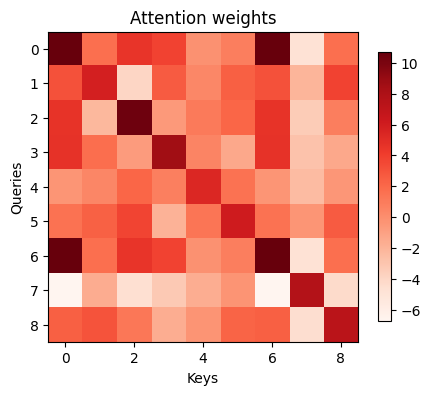

In [14]:
show_attention(output.squeeze(1))

In [15]:
attention2 = output.squeeze(1).softmax(dim=-1)

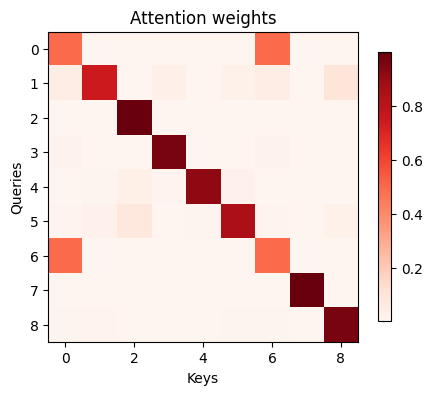

In [16]:
show_attention(attention2)